# Hazme mi trabajo


---


In [1]:
### Cargar las librerías necesarias para el cargado de los datos y la normalización
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os

2023-02-15 10:45:03.561205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 10:45:03.696070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 10:45:03.696088: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-15 10:45:03.717042: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-15 10:45:04.368362: W tensorflow/stream_executor/platform/de

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.layers import LSTM
import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
### Cargar los datos
dataset = pd.read_csv('Copia de Glucose Level - T1D - FreeStyle Libre.csv')

In [5]:
#Comienzo a hacer un EDA
dataset

,ID,Date,Glucose level
0,LIB193263,2020-06-09 19:08:00,99.0
1,LIB193263,2020-06-09 19:23:00,92.0
2,LIB193263,2020-06-09 19:38:00,86.0
3,LIB193263,2020-06-09 19:53:00,85.0
4,LIB193263,2020-06-09 20:08:00,85.0
...,...,...,...
2999996,LIB193399,2020-10-20 20:50:00,83.0
2999997,LIB193399,2020-10-20 21:05:00,76.0
2999998,LIB193399,2020-10-20 21:20:00,67.0
2999999,LIB193399,2020-10-20 21:35:00,63.0


In [6]:
dataset.nunique()

ID                   108
Date             1219797
Glucose level        461
dtype: int64

In [7]:
dataset.shape

(3000001, 3)

In [8]:
print(f"El tamaño del dataset es: {dataset.size}")

El tamaño del dataset es: 9000003


array([[<AxesSubplot: xlabel='Glucose level', ylabel='Glucose level'>]],
      dtype=object)

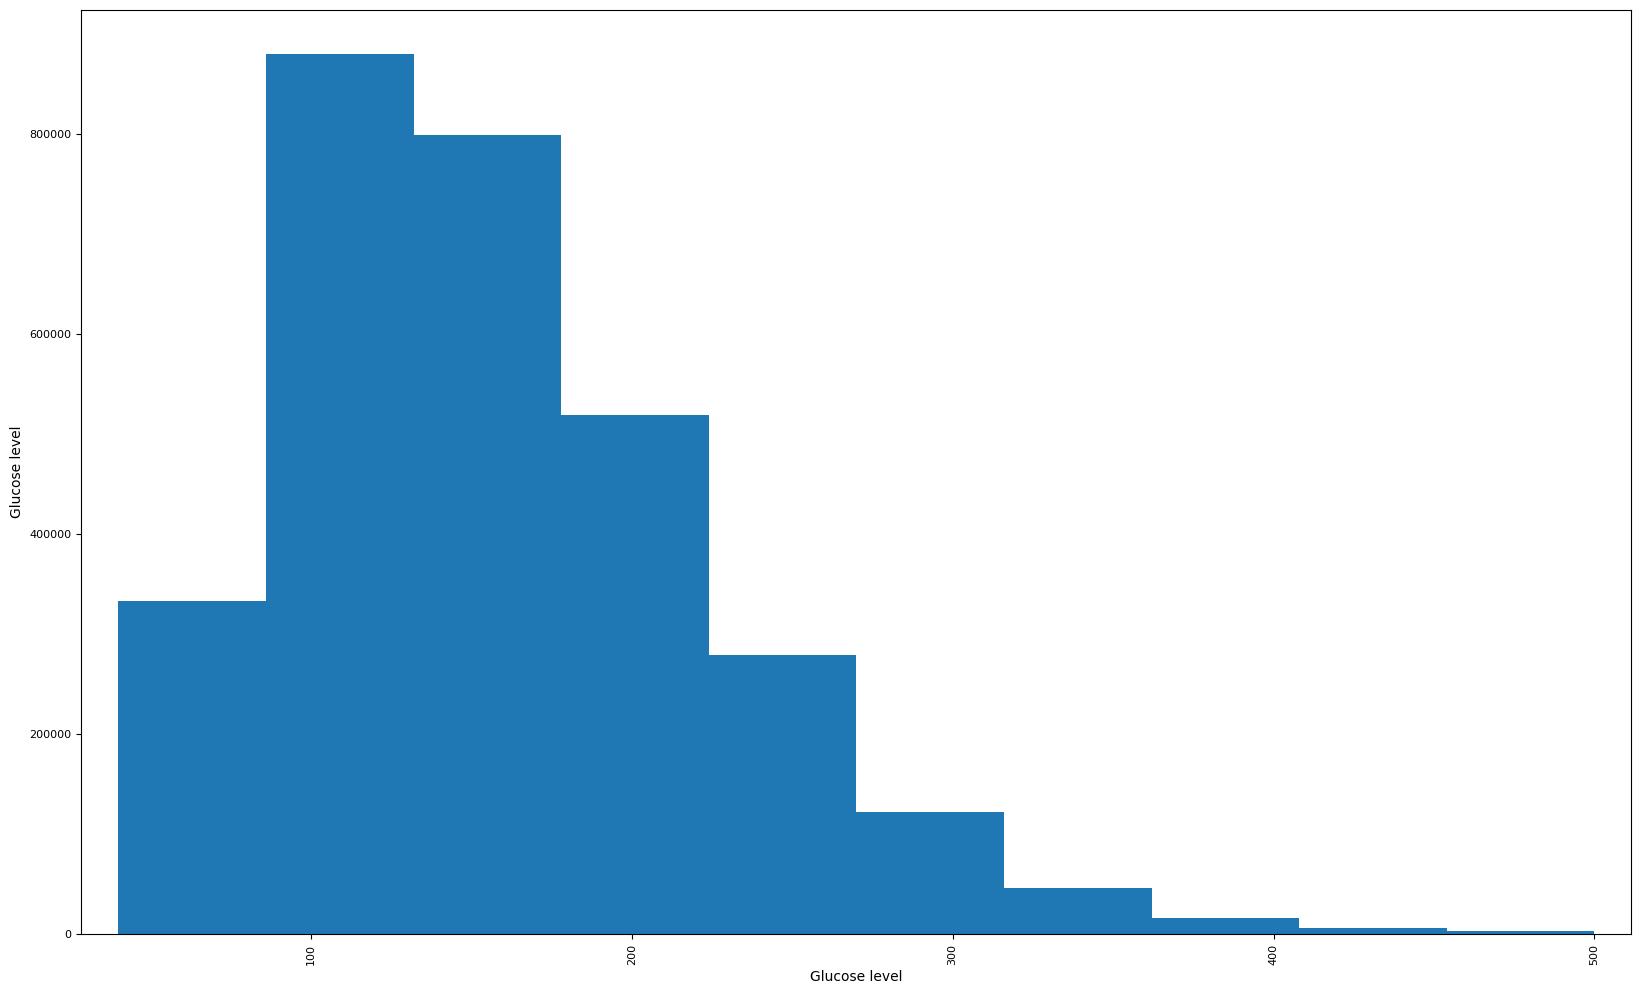

In [9]:
# dataset.set_index('Date', inplace=True)
from pandas.plotting import scatter_matrix
scatter_matrix(dataset, figsize=(20,12))

In [10]:
dataset['ID'].unique()

array(['LIB193263', 'LIB193264', 'LIB193265', 'LIB193266', 'LIB193267',
       'LIB193268', 'LIB193269', 'LIB193270', 'LIB193271', 'LIB193272',
       'LIB193273', 'LIB193274', 'LIB193275', 'LIB193276', 'LIB193277',
       'LIB193278', 'LIB193279', 'LIB193280', 'LIB193281', 'LIB193282',
       'LIB193283', 'LIB193284', 'LIB193302', 'LIB193303', 'LIB193304',
       'LIB193305', 'LIB193306', 'LIB193307', 'LIB193308', 'LIB193309',
       'LIB193310', 'LIB193311', 'LIB193312', 'LIB193313', 'LIB193314',
       'LIB193315', 'LIB193316', 'LIB193317', 'LIB193318', 'LIB193319',
       'LIB193320', 'LIB193321', 'LIB193324', 'LIB193325', 'LIB193326',
       'LIB193327', 'LIB193328', 'LIB193330', 'LIB193331', 'LIB193332',
       'LIB193333', 'LIB193334', 'LIB193335', 'LIB193337', 'LIB193338',
       'LIB193339', 'LIB193340', 'LIB193341', 'LIB193342', 'LIB193343',
       'LIB193344', 'LIB193345', 'LIB193346', 'LIB193347', 'LIB193349',
       'LIB193350', 'LIB193351', 'LIB193352', 'LIB193353', 'LIB1

In [11]:
dataset['ID'].value_counts() #Eliminar el ID LIB193321 por tener solamente 2 datos

LIB193277    114598
LIB193385    114107
LIB193307    104058
LIB193309     77289
LIB193367     76925
              ...  
LIB193366      1287
LIB193398      1253
LIB193283      1098
LIB193365      1057
LIB193321         2
Name: ID, Length: 108, dtype: int64

In [12]:
dataset = dataset.drop(dataset[dataset["ID"]=='LIB193321'].index)

In [13]:
# Testing Datasets
dataset_LIB193263 = dataset.loc[dataset['ID'] == 'LIB193263']
dataset_LIB193263 = dataset_LIB193263.drop(['ID'], axis=1)

Observemos los datos cargados

In [14]:
dataset_LIB193317 = dataset.loc[dataset['ID'] == 'LIB193317']
dataset_LIB193317 = dataset_LIB193317.drop(['ID'], axis=1)

In [15]:
dataset_LIB193366 = dataset.loc[dataset['ID'] == 'LIB193366']
dataset_LIB193366 = dataset_LIB193366.drop(['ID'], axis=1)

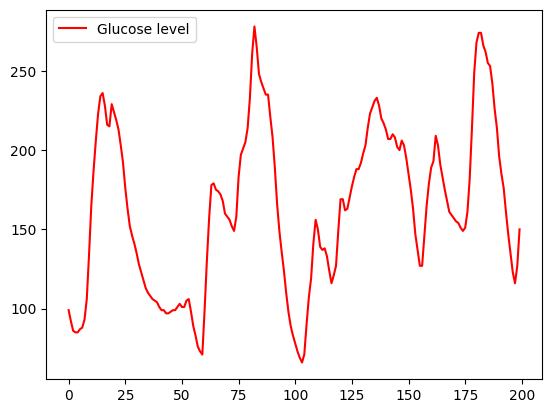

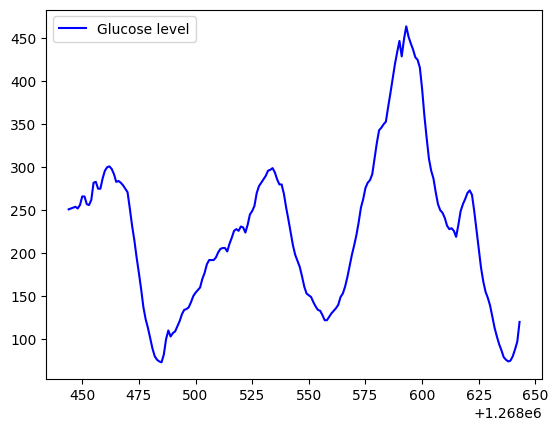

In [16]:
dataset_LIB193263[:200].plot(color='red')
dataset_LIB193317[:200].plot(color='blue')
plt.show()

### Parte 2: Cortar la serie ordenada en secuencias

Generalmente se representa matemáticamente una serie ordenada como:

$$s_{0},s_{1},s_{2},...,s_{P}$$


donde $s_{p}$ es el valor numérico de la serie en el intervalo de tiempo $p$ , siendo  $P$ el largo total de la serie. Para aplicar el RNN se debe tratar a la predicción como un problema de regresión. Para ello se debe usar una ventana móvil para construir un set asociado de pares de entrada-salida sobre los cuales aplicar la regresión.

Por ejemplo, para una ventana de tamaño T = 3 se deben producir los siguientes pares:

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3}\rangle} & \color{Goldenrod}{ s_{4}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4} \rangle } & \color{Goldenrod} {s_{5} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$


####Ventana móvil
Completar la función llamada **window_transform_series** que ejecuta una ventana móvil a lo largo de una serie de datos y crea los pares de input y output necesarios para el entrenamiento.

La función recibe la serie de datos y el tamaño de la ventana (3 en el ejemplo de arriba). Se debe retornar un numpy array.

In [17]:
def window_transform_series(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
      row = [[a] for a in df_as_np[i:i+window_size]]
      X.append(row)
      label = df_as_np[i+window_size]
      y.append(label)
    return np.array(X), np.array(y)

### Probar la función window_transform_series
A continuación probar el código recién programado. Puede ser sobre la serie de datos del problema o sobre otra serie de datos cuya secuencia sea conocida (por ejemplo Fibonacci).

In [31]:
# Original Data
dataset_LIB193263

,Date,Glucose level
0,2020-06-09 19:08:00,99.0
1,2020-06-09 19:23:00,92.0
2,2020-06-09 19:38:00,86.0
3,2020-06-09 19:53:00,85.0
4,2020-06-09 20:08:00,85.0
...,...,...
60093,2022-03-19 06:32:00,124.0
60094,2022-03-19 06:47:00,124.0
60095,2022-03-19 07:02:00,118.0
60096,2022-03-19 07:17:00,110.0


In [32]:
dataset_LIB193263.shape

(60098, 2)

In [33]:
### @TODO
# Utilizar una ventana de tamaño 2 y obtener el siguiente número de la serie
window_size = 5
X1,y1 = window_transform_series(dataset_LIB193263['Glucose level'], window_size)

In [34]:
# Transformed Data
print ('El input X es:')
print (X1)
print(f"El tamaño de X es: {len(X1)}\n")

print ('El output y asociado es:')
print (y1)
print(f"EL tamaño de y es: {y1.size}")

El input X es:
[[[ 99.]
  [ 92.]
  [ 86.]
  [ 85.]
  [ 85.]]

 [[ 92.]
  [ 86.]
  [ 85.]
  [ 85.]
  [ 87.]]

 [[ 86.]
  [ 85.]
  [ 85.]
  [ 87.]
  [ 88.]]

 ...

 [[125.]
  [126.]
  [123.]
  [124.]
  [124.]]

 [[126.]
  [123.]
  [124.]
  [124.]
  [118.]]

 [[123.]
  [124.]
  [124.]
  [118.]
  [110.]]]
El tamaño de X es: 60093

El output y asociado es:
[ 87.  88.  93. ... 118. 110. 105.]
EL tamaño de y es: 60093


### Parte 3: Separar los datos en datos de entrenamiento y de test
Se recomienda separar al menos un tercio de los datos para validación o test. Hacer eso a continuación. Aprovechar que es una serie ordenada y no hacer un split aleatorio de los datos para separar en test y train.

In [75]:
len(X1)    

60093

In [78]:
# Separar los datos en entrenamiento y test
X_train1, y_train1 = X1[:round(len(X1)*0.7)], y1[:round(len(X1)*0.7)]
X_val1, y_val1 = X1[round(len(X1)*0.7):round(len(X1)*0.85)], y1[round(len(X1)*0.7):round(len(X1)*0.85)]
X_test1, y_test1 = X1[round(len(X1)*0.85):], y1[round(len(X1)*0.85):]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((42065, 5, 1), (42065,), (9014, 5, 1), (9014,), (9014, 5, 1), (9014,))

In [24]:
# IMPORTANTE: para utilizar el módulo RNN LSTM de Keras el input debe tener la forma [samples, window size, stepsize]
#Estas transformaciones se hacen a continuación
# X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
# X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

###Parte 4: Crear y ejecutar un modelo de regresión utilizando RNN

Se utilizará Keras para construir una red neuronal con dos capas ocultas RNN con las siguientes especificaciones:

* La capa 1 debe usar un módulo LSTM con 5 unidades ocultas (el input_shape de la misma debe ser (window_size,1))
* La capa 2 usa un módulo completamente conectado (fully connected) con una unidad
* Se debe usar la función de pérdida 'mean_squared_error'

Ayudas:

* [Documentación general de Keras](https://keras.io/getting-started/sequential-model-guide/)
* [Documentación de Keras de LTSM](https://keras.io/layers/recurrent/)
* Asegurarse de inicializar el [optimizador recomendado por Keras para RNN](https://keras.io/optimizers/)

In [50]:
%load_ext tensorboard

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((window_size, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


Entrenar el modelo con los datos separados para esta función haciendo uso de la función fit.

Sugerencia: Investigar y probar con distintos valores de epochs y tamaño de batch. Buscar en la documentación de keras por más información.


In [65]:
cp1 = ModelCheckpoint('/home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/', save_best_only=True)

In [66]:
log_dir = "model2/logs/fit/"
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [67]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)

In [ ]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [68]:
# Hacer fit
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=120, callbacks=[cp1,tb,es])#

Epoch 1/120
1236/1250 [============================>.] - ETA: 0s - loss: 31872.6367 - root_mean_squared_error: 178.5291

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 8s 5ms/step - loss: 31834.9609 - root_mean_squared_error: 178.4235 - val_loss: 26233.7461 - val_root_mean_squared_error: 161.9684
Epoch 2/120
1237/1250 [============================>.] - ETA: 0s - loss: 23187.5215 - root_mean_squared_error: 152.2745

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 23144.0137 - root_mean_squared_error: 152.1316 - val_loss: 18252.6133 - val_root_mean_squared_error: 135.1022
Epoch 3/120
1234/1250 [============================>.] - ETA: 0s - loss: 15322.9209 - root_mean_squared_error: 123.7858

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 15292.4443 - root_mean_squared_error: 123.6626 - val_loss: 11262.1396 - val_root_mean_squared_error: 106.1232
Epoch 4/120
1243/1250 [============================>.] - ETA: 0s - loss: 9110.2305 - root_mean_squared_error: 95.4475

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 9089.8809 - root_mean_squared_error: 95.3409 - val_loss: 6134.2798 - val_root_mean_squared_error: 78.3216
Epoch 5/120
1232/1250 [============================>.] - ETA: 0s - loss: 4805.3662 - root_mean_squared_error: 69.3207

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 4780.6445 - root_mean_squared_error: 69.1422 - val_loss: 2963.5837 - val_root_mean_squared_error: 54.4388
Epoch 6/120
1247/1250 [============================>.] - ETA: 0s - loss: 2318.0869 - root_mean_squared_error: 48.1465

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 4ms/step - loss: 2316.7393 - root_mean_squared_error: 48.1325 - val_loss: 1339.1970 - val_root_mean_squared_error: 36.5950
Epoch 7/120
1239/1250 [============================>.] - ETA: 0s - loss: 1119.5310 - root_mean_squared_error: 33.4594

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 1116.0258 - root_mean_squared_error: 33.4070 - val_loss: 623.9313 - val_root_mean_squared_error: 24.9786
Epoch 8/120
1238/1250 [============================>.] - ETA: 0s - loss: 568.6569 - root_mean_squared_error: 23.8465

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 568.5297 - root_mean_squared_error: 23.8439 - val_loss: 324.9673 - val_root_mean_squared_error: 18.0268
Epoch 9/120
1234/1250 [============================>.] - ETA: 0s - loss: 320.3983 - root_mean_squared_error: 17.8997

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 4ms/step - loss: 318.3738 - root_mean_squared_error: 17.8430 - val_loss: 198.1651 - val_root_mean_squared_error: 14.0771
Epoch 10/120
1231/1250 [============================>.] - ETA: 0s - loss: 202.7589 - root_mean_squared_error: 14.2393

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 202.7222 - root_mean_squared_error: 14.2381 - val_loss: 141.1671 - val_root_mean_squared_error: 11.8814
Epoch 11/120
1241/1250 [============================>.] - ETA: 0s - loss: 146.7335 - root_mean_squared_error: 12.1134

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 146.9044 - root_mean_squared_error: 12.1204 - val_loss: 111.4172 - val_root_mean_squared_error: 10.5554
Epoch 12/120
1246/1250 [============================>.] - ETA: 0s - loss: 117.6232 - root_mean_squared_error: 10.8454

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 117.4431 - root_mean_squared_error: 10.8371 - val_loss: 92.6887 - val_root_mean_squared_error: 9.6275
Epoch 13/120
1244/1250 [============================>.] - ETA: 0s - loss: 100.9599 - root_mean_squared_error: 10.0479

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 100.8468 - root_mean_squared_error: 10.0422 - val_loss: 81.1650 - val_root_mean_squared_error: 9.0092
Epoch 14/120
1233/1250 [============================>.] - ETA: 0s - loss: 91.6714 - root_mean_squared_error: 9.5745

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 4ms/step - loss: 91.2837 - root_mean_squared_error: 9.5543 - val_loss: 74.7372 - val_root_mean_squared_error: 8.6451
Epoch 15/120
1250/1250 [==============================] - ETA: 0s - loss: 85.2707 - root_mean_squared_error: 9.2342

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 85.2707 - root_mean_squared_error: 9.2342 - val_loss: 71.4476 - val_root_mean_squared_error: 8.4527
Epoch 16/120
1232/1250 [============================>.] - ETA: 0s - loss: 81.9147 - root_mean_squared_error: 9.0507

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 81.4739 - root_mean_squared_error: 9.0263 - val_loss: 68.0970 - val_root_mean_squared_error: 8.2521
Epoch 17/120
1249/1250 [============================>.] - ETA: 0s - loss: 79.0680 - root_mean_squared_error: 8.8920

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 4ms/step - loss: 79.0610 - root_mean_squared_error: 8.8916 - val_loss: 66.2703 - val_root_mean_squared_error: 8.1407
Epoch 18/120
1230/1250 [============================>.] - ETA: 0s - loss: 77.5503 - root_mean_squared_error: 8.8063

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 4ms/step - loss: 77.2729 - root_mean_squared_error: 8.7905 - val_loss: 64.0653 - val_root_mean_squared_error: 8.0041
Epoch 19/120
1243/1250 [============================>.] - ETA: 0s - loss: 75.9203 - root_mean_squared_error: 8.7132

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 7s 6ms/step - loss: 75.7957 - root_mean_squared_error: 8.7061 - val_loss: 63.1447 - val_root_mean_squared_error: 7.9464
Epoch 20/120
1231/1250 [============================>.] - ETA: 0s - loss: 74.6751 - root_mean_squared_error: 8.6415

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 74.7832 - root_mean_squared_error: 8.6477 - val_loss: 62.2396 - val_root_mean_squared_error: 7.8892
Epoch 21/120
1248/1250 [============================>.] - ETA: 0s - loss: 74.2323 - root_mean_squared_error: 8.6158

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 74.2489 - root_mean_squared_error: 8.6168 - val_loss: 61.9617 - val_root_mean_squared_error: 7.8716
Epoch 22/120
1248/1250 [============================>.] - ETA: 0s - loss: 73.5187 - root_mean_squared_error: 8.5743

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 73.4636 - root_mean_squared_error: 8.5711 - val_loss: 60.8087 - val_root_mean_squared_error: 7.7980
Epoch 23/120
1250/1250 [==============================] - 3s 3ms/step - loss: 72.8903 - root_mean_squared_error: 8.5376 - val_loss: 61.4226 - val_root_mean_squared_error: 7.8373
Epoch 24/120
1250/1250 [==============================] - 3s 3ms/step - loss: 72.7262 - root_mean_squared_error: 8.5280 - val_loss: 61.1671 - val_root_mean_squared_error: 7.8209
Epoch 25/120
1250/1250 [==============================] - 3s 2ms/step - loss: 72.3154 - root_mean_squared_error: 8.5038 - val_loss: 61.0671 - val_root_mean_squared_error: 7.8145
Epoch 26/120
1245/1250 [============================>.] - ETA: 0s - loss: 72.0478 - root_mean_squared_error: 8.4881

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 71.9777 - root_mean_squared_error: 8.4840 - val_loss: 60.2264 - val_root_mean_squared_error: 7.7606
Epoch 27/120
1250/1250 [==============================] - 3s 3ms/step - loss: 71.9086 - root_mean_squared_error: 8.4799 - val_loss: 60.2665 - val_root_mean_squared_error: 7.7632
Epoch 28/120
1250/1250 [==============================] - 4s 3ms/step - loss: 71.4699 - root_mean_squared_error: 8.4540 - val_loss: 61.3960 - val_root_mean_squared_error: 7.8356
Epoch 29/120
1243/1250 [============================>.] - ETA: 0s - loss: 71.2614 - root_mean_squared_error: 8.4416

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 7s 5ms/step - loss: 71.1996 - root_mean_squared_error: 8.4380 - val_loss: 59.9298 - val_root_mean_squared_error: 7.7414
Epoch 30/120
1250/1250 [==============================] - 3s 3ms/step - loss: 71.3136 - root_mean_squared_error: 8.4447 - val_loss: 60.2266 - val_root_mean_squared_error: 7.7606
Epoch 31/120
1250/1250 [==============================] - 3s 2ms/step - loss: 70.8663 - root_mean_squared_error: 8.4182 - val_loss: 60.6279 - val_root_mean_squared_error: 7.7864
Epoch 32/120
1250/1250 [==============================] - 3s 3ms/step - loss: 70.8330 - root_mean_squared_error: 8.4162 - val_loss: 59.9494 - val_root_mean_squared_error: 7.7427
Epoch 33/120
1233/1250 [============================>.] - ETA: 0s - loss: 70.8566 - root_mean_squared_error: 8.4176

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 4ms/step - loss: 70.7073 - root_mean_squared_error: 8.4088 - val_loss: 58.8882 - val_root_mean_squared_error: 7.6739
Epoch 34/120
1231/1250 [============================>.] - ETA: 0s - loss: 70.7846 - root_mean_squared_error: 8.4134

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 70.5854 - root_mean_squared_error: 8.4015 - val_loss: 58.7498 - val_root_mean_squared_error: 7.6648
Epoch 35/120
1250/1250 [==============================] - 3s 3ms/step - loss: 70.5351 - root_mean_squared_error: 8.3985 - val_loss: 59.1957 - val_root_mean_squared_error: 7.6939
Epoch 36/120
1250/1250 [==============================] - 3s 3ms/step - loss: 70.4351 - root_mean_squared_error: 8.3926 - val_loss: 58.9163 - val_root_mean_squared_error: 7.6757
Epoch 37/120
1250/1250 [==============================] - 3s 3ms/step - loss: 70.3531 - root_mean_squared_error: 8.3877 - val_loss: 59.7707 - val_root_mean_squared_error: 7.7311
Epoch 38/120
1231/1250 [============================>.] - ETA: 0s - loss: 70.4982 - root_mean_squared_error: 8.3963

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 70.2247 - root_mean_squared_error: 8.3800 - val_loss: 58.5567 - val_root_mean_squared_error: 7.6522
Epoch 39/120
1250/1250 [==============================] - 3s 3ms/step - loss: 70.1327 - root_mean_squared_error: 8.3745 - val_loss: 58.6623 - val_root_mean_squared_error: 7.6591
Epoch 40/120
1250/1250 [==============================] - 3s 2ms/step - loss: 69.8244 - root_mean_squared_error: 8.3561 - val_loss: 59.6866 - val_root_mean_squared_error: 7.7257
Epoch 41/120
1250/1250 [==============================] - 3s 2ms/step - loss: 69.9752 - root_mean_squared_error: 8.3651 - val_loss: 58.6671 - val_root_mean_squared_error: 7.6594
Epoch 42/120
1250/1250 [==============================] - 3s 2ms/step - loss: 69.9045 - root_mean_squared_error: 8.3609 - val_loss: 61.4233 - val_root_mean_squared_error: 7.8373
Epoch 43/120
1250/1250 [==============================] - 3s 3ms/step - loss: 69.8377 - root_mean_squared_error: 8.3569 - v

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 69.5098 - root_mean_squared_error: 8.3373 - val_loss: 58.1173 - val_root_mean_squared_error: 7.6235
Epoch 46/120
1250/1250 [==============================] - 3s 2ms/step - loss: 69.5276 - root_mean_squared_error: 8.3383 - val_loss: 62.1750 - val_root_mean_squared_error: 7.8851
Epoch 47/120
1250/1250 [==============================] - 3s 2ms/step - loss: 69.3966 - root_mean_squared_error: 8.3305 - val_loss: 58.6442 - val_root_mean_squared_error: 7.6580
Epoch 48/120
1250/1250 [==============================] - 3s 2ms/step - loss: 69.4308 - root_mean_squared_error: 8.3325 - val_loss: 58.3605 - val_root_mean_squared_error: 7.6394
Epoch 49/120
1250/1250 [==============================] - 3s 3ms/step - loss: 69.4219 - root_mean_squared_error: 8.3320 - val_loss: 58.7752 - val_root_mean_squared_error: 7.6665
Epoch 50/120
1250/1250 [==============================] - 3s 3ms/step - loss: 69.2874 - root_mean_squared_error: 8.3239 - v

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 69.0966 - root_mean_squared_error: 8.3124 - val_loss: 58.0435 - val_root_mean_squared_error: 7.6186
Epoch 56/120
1249/1250 [============================>.] - ETA: 0s - loss: 69.0028 - root_mean_squared_error: 8.3068

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 68.9669 - root_mean_squared_error: 8.3046 - val_loss: 57.8175 - val_root_mean_squared_error: 7.6038
Epoch 57/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.9294 - root_mean_squared_error: 8.3024 - val_loss: 60.5899 - val_root_mean_squared_error: 7.7840
Epoch 58/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.8798 - root_mean_squared_error: 8.2994 - val_loss: 57.8183 - val_root_mean_squared_error: 7.6038
Epoch 59/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.8331 - root_mean_squared_error: 8.2966 - val_loss: 58.0802 - val_root_mean_squared_error: 7.6210
Epoch 60/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.9669 - root_mean_squared_error: 8.3046 - val_loss: 58.3694 - val_root_mean_squared_error: 7.6400
Epoch 61/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.9439 - root_mean_squared_error: 8.3032 - v

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 68.8972 - root_mean_squared_error: 8.3004 - val_loss: 57.6564 - val_root_mean_squared_error: 7.5932
Epoch 65/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.8865 - root_mean_squared_error: 8.2998 - val_loss: 57.7572 - val_root_mean_squared_error: 7.5998
Epoch 66/120
1247/1250 [============================>.] - ETA: 0s - loss: 68.6769 - root_mean_squared_error: 8.2872

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 68.6481 - root_mean_squared_error: 8.2854 - val_loss: 57.3923 - val_root_mean_squared_error: 7.5758
Epoch 67/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.4917 - root_mean_squared_error: 8.2760 - val_loss: 57.7314 - val_root_mean_squared_error: 7.5981
Epoch 68/120
1226/1250 [============================>.] - ETA: 0s - loss: 68.6554 - root_mean_squared_error: 8.2859

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 68.5494 - root_mean_squared_error: 8.2795 - val_loss: 57.2950 - val_root_mean_squared_error: 7.5693
Epoch 69/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.2108 - root_mean_squared_error: 8.2590 - val_loss: 57.6322 - val_root_mean_squared_error: 7.5916
Epoch 70/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.3131 - root_mean_squared_error: 8.2652 - val_loss: 62.1532 - val_root_mean_squared_error: 7.8837
Epoch 71/120
1239/1250 [============================>.] - ETA: 0s - loss: 68.5504 - root_mean_squared_error: 8.2795

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 68.3523 - root_mean_squared_error: 8.2675 - val_loss: 57.1493 - val_root_mean_squared_error: 7.5597
Epoch 72/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.4239 - root_mean_squared_error: 8.2719 - val_loss: 57.4922 - val_root_mean_squared_error: 7.5824
Epoch 73/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.1571 - root_mean_squared_error: 8.2557 - val_loss: 57.7157 - val_root_mean_squared_error: 7.5971
Epoch 74/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.1990 - root_mean_squared_error: 8.2583 - val_loss: 57.3509 - val_root_mean_squared_error: 7.5730
Epoch 75/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.1285 - root_mean_squared_error: 8.2540 - val_loss: 58.7661 - val_root_mean_squared_error: 7.6659
Epoch 76/120
1250/1250 [==============================] - 3s 2ms/step - loss: 68.0645 - root_mean_squared_error: 8.2501 - v

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 68.1598 - root_mean_squared_error: 8.2559 - val_loss: 57.1334 - val_root_mean_squared_error: 7.5587
Epoch 80/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.8629 - root_mean_squared_error: 8.2379 - val_loss: 57.2891 - val_root_mean_squared_error: 7.5690
Epoch 81/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.8344 - root_mean_squared_error: 8.2362 - val_loss: 57.3716 - val_root_mean_squared_error: 7.5744
Epoch 82/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.8695 - root_mean_squared_error: 8.2383 - val_loss: 57.5980 - val_root_mean_squared_error: 7.5893
Epoch 83/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.9195 - root_mean_squared_error: 8.2413 - val_loss: 58.0796 - val_root_mean_squared_error: 7.6210
Epoch 84/120
1248/1250 [============================>.] - ETA: 0s - loss: 67.8984 - root_mean_squared_error: 8.2400

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 67.8694 - root_mean_squared_error: 8.2383 - val_loss: 57.0358 - val_root_mean_squared_error: 7.5522
Epoch 85/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.7860 - root_mean_squared_error: 8.2332 - val_loss: 57.5392 - val_root_mean_squared_error: 7.5855
Epoch 86/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.9664 - root_mean_squared_error: 8.2442 - val_loss: 57.4772 - val_root_mean_squared_error: 7.5814
Epoch 87/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.8020 - root_mean_squared_error: 8.2342 - val_loss: 57.1410 - val_root_mean_squared_error: 7.5592
Epoch 88/120
1245/1250 [============================>.] - ETA: 0s - loss: 67.7218 - root_mean_squared_error: 8.2293

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 67.6318 - root_mean_squared_error: 8.2239 - val_loss: 56.8432 - val_root_mean_squared_error: 7.5394
Epoch 89/120
1250/1250 [==============================] - 3s 3ms/step - loss: 67.6820 - root_mean_squared_error: 8.2269 - val_loss: 58.1103 - val_root_mean_squared_error: 7.6230
Epoch 90/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.7037 - root_mean_squared_error: 8.2282 - val_loss: 58.6637 - val_root_mean_squared_error: 7.6592
Epoch 91/120
1248/1250 [============================>.] - ETA: 0s - loss: 67.5697 - root_mean_squared_error: 8.2201

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 67.5972 - root_mean_squared_error: 8.2218 - val_loss: 56.7178 - val_root_mean_squared_error: 7.5311
Epoch 92/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.5780 - root_mean_squared_error: 8.2206 - val_loss: 58.8880 - val_root_mean_squared_error: 7.6739
Epoch 93/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.6440 - root_mean_squared_error: 8.2246 - val_loss: 56.8904 - val_root_mean_squared_error: 7.5426
Epoch 94/120
1229/1250 [============================>.] - ETA: 0s - loss: 67.9060 - root_mean_squared_error: 8.2405

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 67.6145 - root_mean_squared_error: 8.2228 - val_loss: 56.6166 - val_root_mean_squared_error: 7.5244
Epoch 95/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.5382 - root_mean_squared_error: 8.2182 - val_loss: 57.6248 - val_root_mean_squared_error: 7.5911
Epoch 96/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.7243 - root_mean_squared_error: 8.2295 - val_loss: 56.9272 - val_root_mean_squared_error: 7.5450
Epoch 97/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.5229 - root_mean_squared_error: 8.2172 - val_loss: 56.7002 - val_root_mean_squared_error: 7.5300
Epoch 98/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.4907 - root_mean_squared_error: 8.2153 - val_loss: 56.9835 - val_root_mean_squared_error: 7.5487
Epoch 99/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.6655 - root_mean_squared_error: 8.2259 - v

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 67.1876 - root_mean_squared_error: 8.1968 - val_loss: 56.5143 - val_root_mean_squared_error: 7.5176
Epoch 112/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.1303 - root_mean_squared_error: 8.1933 - val_loss: 57.2638 - val_root_mean_squared_error: 7.5673
Epoch 113/120
1227/1250 [============================>.] - ETA: 0s - loss: 67.1922 - root_mean_squared_error: 8.1971

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 5s 4ms/step - loss: 67.2034 - root_mean_squared_error: 8.1978 - val_loss: 56.4828 - val_root_mean_squared_error: 7.5155
Epoch 114/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.1781 - root_mean_squared_error: 8.1962 - val_loss: 57.3016 - val_root_mean_squared_error: 7.5698
Epoch 115/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.0790 - root_mean_squared_error: 8.1902 - val_loss: 56.7914 - val_root_mean_squared_error: 7.5360
Epoch 116/120
1250/1250 [==============================] - 3s 2ms/step - loss: 66.9327 - root_mean_squared_error: 8.1812 - val_loss: 56.8771 - val_root_mean_squared_error: 7.5417
Epoch 117/120
1250/1250 [==============================] - 3s 2ms/step - loss: 67.1014 - root_mean_squared_error: 8.1915 - val_loss: 57.2050 - val_root_mean_squared_error: 7.5634
Epoch 118/120
1250/1250 [==============================] - 3s 2ms/step - loss: 66.9283 - root_mean_squared_error: 8.181

INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


INFO:tensorflow:Assets written to: /home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model2/assets


1250/1250 [==============================] - 6s 5ms/step - loss: 67.2197 - root_mean_squared_error: 8.1988 - val_loss: 56.2056 - val_root_mean_squared_error: 7.4970


###Parte 5: Medir la performance del modelo
Ahora estamos en condiciones de hacer una predicción

In [ ]:
#To load a previously trained model
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

Ahora grafiquemos los datos:

In [69]:
# Hacer la predicción con el modelo entrenado 
# TRAIN
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

1250/1250 [==============================] - 2s 1ms/step


,Train Predictions,Actuals
0,86.312157,87.0
1,91.829247,88.0
2,89.599762,93.0
3,100.643921,106.0
4,118.676094,134.0
...,...,...
39995,138.669312,123.0
39996,106.571854,98.0
39997,87.297287,95.0
39998,101.081680,111.0


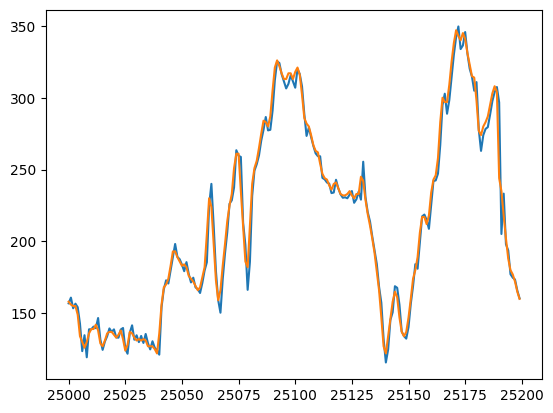

In [80]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][25000:25200])
plt.plot(train_results['Actuals'][25000:25200])

In [52]:
# VALIDATION
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

313/313 [==============================] - 0s 1ms/step


,Train Predictions,Actuals
0,100.284637,88.0
1,76.613579,73.0
2,70.198860,66.0
3,64.259811,61.0
4,61.392971,58.0
...,...,...
9995,144.493607,150.0
9996,151.470032,149.0
9997,147.001312,142.0
9998,134.924133,136.0


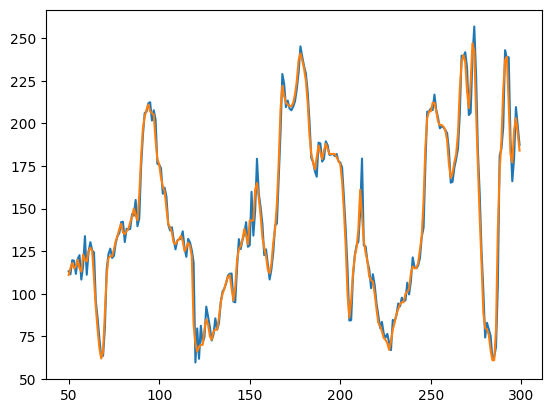

In [53]:
plt.plot(val_results['Train Predictions'][50:300])
plt.plot(val_results['Actuals'][50:300])

In [71]:
# TEST
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

316/316 [==============================] - 1s 1ms/step


,Train Predictions,Actuals
0,135.888580,134.0
1,132.390869,131.0
2,129.632202,128.0
3,127.551132,128.0
4,129.949463,128.0
...,...,...
10088,120.323792,124.0
10089,128.991013,124.0
10090,122.413795,118.0
10091,113.300644,110.0


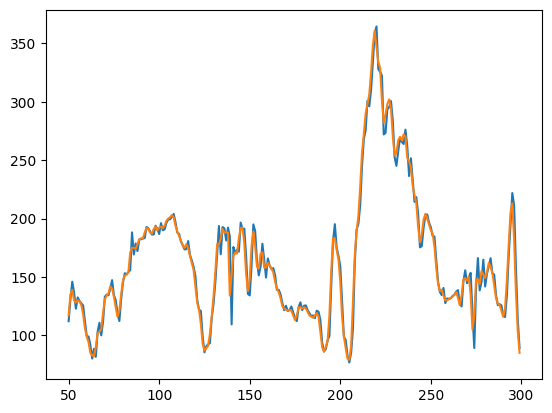

In [72]:
plt.plot(test_results['Train Predictions'][50:300])
plt.plot(test_results['Actuals'][50:300])

In [ ]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

Se debería obtener un error sobre los datos de entrenamiento como de test menor al 2%. Si no se consigue este valor, se puede aumentar el número de epochs y re-entrenar el modelo o ajustar el tamaño del batch. Estudiar en la documentación que otros hiper-parámetros se pueden modificar para mejorar la precisión.

In [73]:
%tensorboard --logdir model2/logs/fit

Nota:[Aquí](https://datamarket.com/data/list/?q=provider%3Atsdl) se pueden encontrar otras series ordenadas con las que probar

(Completar respuesta aquí)

###Parte 4: Crear y ejecutar un modelo de regresión utilizando MLP

In [85]:
model2=Sequential()
model2.add(Dense(128, input_dim=window_size, activation='relu'))
model2.add(Dense(128, input_dim=window_size, activation='relu'))
model2.add(Dense(1))
model2.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               768       
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00025), metrics=[RootMeanSquaredError()])

In [ ]:
cp2 = ModelCheckpoint('/home/manuelquiros/Documents/HazMiTrabajo/01- LSTM_Glucosa/model3_MLP/', save_best_only=True)
log_dir2 = "model3_MLP/logs/fit/"
tb2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)

In [ ]:
model2.fit(X_train1, y_train1, epochs=20, batch_size=2, verbose=2)

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=120, callbacks=[cp1,tb,es])

### Medir la performance del modelo

In [ ]:
import math

In [ ]:
TrainScore=model_2.evaluate(X_train, y_train, verbose=0)
print('Puntuación de entrenamiento: %.4f MSE: (%.2f RMSE)'% (TrainScore, math.sqrt(TrainScore)))

Puntuación de entrenamiento: 0.0004 MSE: (0.02 RMSE)


In [ ]:
TestScore=model_2.evaluate(X_test, y_test, verbose=0)
print('Puntuación de Validación: %.4f MSE: (%.2f RMSE)' %(TestScore, math.sqrt((TestScore))))

Puntuación de Validación: 0.0003 MSE: (0.02 RMSE)


In [ ]:
# Representación
TrainPredict=model_2.predict(X_train)
TestPredict=model_2.predict(X_test)

626/626 [==============================] - 1s 1ms/step


In [ ]:
TrainPredict, TestPredict

(array([[0.09899382],
        [0.10532899],
        [0.10494199],
        ...,
        [0.16310799],
        [0.20462142],
        [0.16981633]], dtype=float32), array([[0.17687872],
        [0.20134355],
        [0.1954624 ],
        ...,
        [0.187639  ],
        [0.16452266],
        [0.14641973]], dtype=float32))

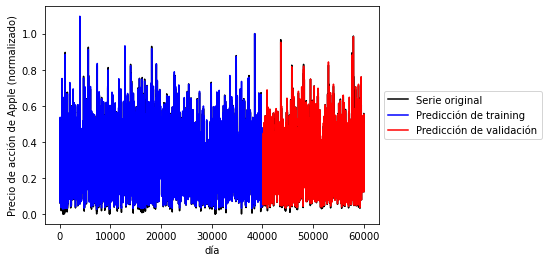

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Graficar serie original
plt.plot(dataset,color = 'k')

# Graficar la predicción de entrenamiento
split_pt = len(train_index) + window_size
plt.plot(np.arange(window_size,split_pt,1),TrainPredict,color = 'b')

# Graficar la predicción de validación
plt.plot(np.arange(split_pt,split_pt + len(TestPredict),1),TestPredict,color = 'r')

# Agregar rótulos
plt.xlabel('día')
plt.ylabel('Precio de acción de Apple (normalizado)')
plt.legend(['Serie original','Predicción de training','Predicción de validación'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# La predicción es muy pobre